In [3]:
from bs4 import BeautifulSoup as BS
from mpl_toolkits.basemap import Basemap
from bokeh.plotting import figure, show 
from bokeh.io import output_notebook, output_file
from bokeh.models import (GeoJSONDataSource, GMapPlot, GMapOptions, DataRange1d, Circle, ColumnDataSource, 
                          PanTool, WheelZoomTool, BoxSelectTool, HoverTool)
import geopandas as gpd
import urllib.request
import pandas as pd
import numpy as np
import re as r
import matplotlib.pyplot as plt
from shapely.geometry import Point

%matplotlib inline

#### Define url as data frame and read in

In [4]:
request = urllib.request.Request('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')
result = urllib.request.urlopen(request)
resulttext = result.read()

#### Use BS constructor to pull data from HTML document 

In [5]:
soup = BS(resulttext, 'html.parser')

#### Look at well formed print of your soup

In [6]:
soup.prettify

<bound method Tag.prettify of <!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of deadly earthquakes since 1900 - Wikipedia</title>
<script>document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );</script>
<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_deadly_earthquakes_since_1900","wgTitle":"List of deadly earthquakes since 1900","wgCurRevisionId":810533305,"wgRevisionId":810533305,"wgArticleId":11673441,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles needing additional references from July 2017","All articles needing additional references","Articles needing cleanup from July 2017","All pages needing cleanup","Cleanup tagged articles with a reason field from Jul

#### Find particular elements in the soup 

In [7]:
data = []
table = soup.find('table', "sortable wikitable")


#### Iterate through your table, grab each row, and pull the < th > and < td > elements into a dataset 

In [8]:
table = table.find_all('tr')

In [9]:
for row in table:
    cells = row.find_all('td')
    cells = [ele.text.strip() for ele in cells]
    data.append(cells)

#### Define data frame and its field names and remove and extraneous records

In [10]:
quake_df = pd.DataFrame(data)
quake_df.drop(0, inplace=True)
quake_df = quake_df.rename(columns={0:'Origin', 1:'Country', 2:'Lat', 3:'Long', 4:'Depth', 5:'Magnitude', 6:'Secondary Effects', 7:'PDE_Shaking', 8:'PDE_Total', 9:'Utsu_Total', 10:'EM_DAT_Total', 11: 'Other'})


#### Replace empty strings with NaN 

In [11]:
quake_df = quake_df.apply(lambda x: x.str.strip()).replace('', np.nan)

#### Remove the footnotes from the 'Other Source Deaths' column

In [12]:
quake_df['Other'] = quake_df.Other.str.replace(r'+','')
quake_df['Other'] = quake_df.Other.str.replace(r',','')
quake_df['Other'] = quake_df.Other.str.extract('(\d+)', expand = True)
quake_df['EM_DAT_Total'] = quake_df.EM_DAT_Total.str.extract('(\d+)', expand = True)

#### Remove the footnotes from the 'Country' column

In [13]:
quake_df['Country'] = quake_df.Country.str.replace(r'\(.*','')

#### Convert Magnitude to a numeric

In [14]:
quake_df['Magnitude'] = quake_df.Magnitude.str.extract('(\d\.\d)', expand = True)

#### Create the Deaths column 

In [15]:
quake_df[['PDE_Total', 'Utsu_Total', 'EM_DAT_Total', 'Other']] = quake_df[['PDE_Total', 'Utsu_Total', 'EM_DAT_Total', 'Other']].fillna(-1)
quake_df['PDE_Total'] = quake_df['PDE_Total'].astype(float)
quake_df['Utsu_Total'] = quake_df['Utsu_Total'].astype(float)
quake_df['EM_DAT_Total']= quake_df['EM_DAT_Total'].astype(float)
quake_df['Other'] = quake_df['Other'].astype(float)

In [18]:
def max(row):
        if row['Other'] >= row['PDE_Total'] and row['Other'] >= row['Utsu_Total'] and row['Other'] >= row['EM_DAT_Total']:
            return row['Other']
    
        elif row['PDE_Total'] >= row['Other'] and row['PDE_Total'] >= row['Utsu_Total'] and row['PDE_Total'] >= row['EM_DAT_Total']:
            return row['PDE_Total']

        elif row['Utsu_Total'] >= row['Other'] and row['Utsu_Total'] >= row['PDE_Total'] and row['Utsu_Total'] >= row['EM_DAT_Total']:
            return row['Utsu_Total']

        else: 
            return row['EM_DAT_Total']

quake_df['Deaths'] = quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other']].apply(max, axis=1)
quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other', 'Deaths']]=quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other', 'Deaths']].replace(-1.0,np.NaN)


#### Read in file with US lat-long

In [19]:
##US_df = gpd.read_file('Data/USA_adm1.shp')
US_df = pd.read_csv('Data/vs30data_utf8.csv')
geometry = [Point(xy) for xy in zip(US_df.Longitude, US_df.Latitude)]
crs = {'init': 'epsg:4326'}


In [20]:
def soil_category(row):
        if row['Vs30 (m/s)'] > 1500:
            return 'Type A'
        
        elif row['Vs30 (m/s)'] <= 1500 and row['Vs30 (m/s)'] > 760:
            return 'Type B'
        
        elif row['Vs30 (m/s)'] <= 760 and row['Vs30 (m/s)'] > 360:
            return 'Type C'
        
        elif row['Vs30 (m/s)'] <= 360 and row['Vs30 (m/s)'] > 180:
            return 'Type D'
        
        elif row['Vs30 (m/s)'] < 180:
            return 'Type E'
        
        else:
            return 'No Category'
    
US_df['SoilProfileType'] = US_df.apply(soil_category, axis= 1)
US_df.head()

,Id,Latitude,Longitude,Datum,Network/Station Code,Station Name,Vs30 (m/s),Max Depth (m),Geologic Map Unit(s)/Material(s),SoilProfileType
0,AM.1,61.235,-149.869,NaN,K2-01,NaN,238.0,NaN,NaN,Type D
1,AM.10,61.156,-149.792,NaN,K2-12,NaN,514.0,NaN,NaN,Type C
2,AM.11,61.113,-149.856,NaN,K2-13,NaN,354.0,NaN,NaN,Type D
3,AM.12,61.087,-149.750,NaN,K2-15,NaN,412.0,NaN,NaN,Type C
4,AM.13,61.178,-150.015,NaN,K2-4,NaN,309.0,NaN,NaN,Type D


In [ ]:
def get_marker_color(magnitude):
    # Returns green for small earthquakes, yellow for moderate
    #  earthquakes, and red for significant earthquakes.
    if SoilProfileType = 'Type A':
        return ('go')
    elif SoilProfileType = 'Type B':
        return ('yo')
    elif SoilProfileType = 'Type C':
        return ('ro')
    elif SoilProfileType = 'Type D':
        return ('bo')
    elif SoilProfileType = 'Type D':
        return ('oo')
    

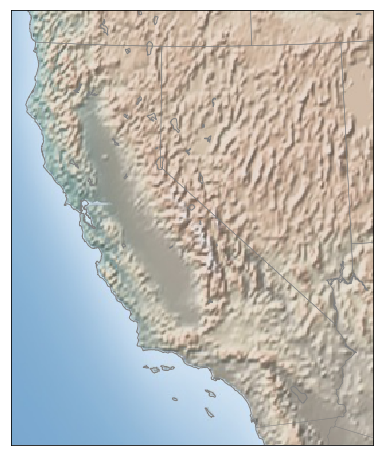

In [41]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h',
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')


(19.0, 20.5)

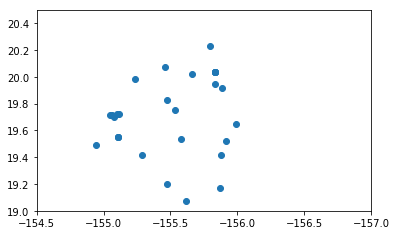

In [150]:
geo_vio = US_df
geo_vio = gpd.GeoDataFrame(geo_vio, geometry = geometry)

geo_vio = geo_vio['geometry']
geo_vio.plot()
plt.xlim(-154.5,-157)
plt.ylim(19.0,20.5)

##US_df.head(5)
##fig, ax = plt.subplots(figsize = (10, 10), subplot_kw = {'aspect': 'equal'})
##US_df.plot(ax=ax, cmap = 'Pastel1');


In [11]:
US_df = gpd.read_file("Data/United_States.geojson")
US_df = US_df.drop(["id", "name"],axis=1)


,geometry
0,"(POLYGON ((-155.54211 19.08348, -155.68817 18...."


#### Create Map of United States

In [39]:
geojson = US_df.to_json()
geo_source = GeoJSONDataSource(geojson=geojson)
p = figure(plot_width=500, plot_height=500, title = "US-Map")
##combined = pd.DataFrame(US_df)
p.circle('x', 'y', alpha=0.9, source=geo_source)
output_file("geojson.html")
show(p)

W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='f9653af1-613a-4ed6-9b09-f74d017d6a70', ...)
W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='ecd25e9d-1e70-4f35-a112-e91a592fca02', ...)
W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='507bb8b6-171b-485c-8e04-99fa211acfcd', ...)
W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='b365c839-3396-4366-b592-8e570f8a1dbe', ...)
